In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-classification-dataset/combined_data.csv


### Import Libraries:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

### Helping Functions:

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support,roc_curve, auc, accuracy_score

# Model Evaluation
def model_evaluation(yt, yp):
    results = {}
    results['accuracy'] = accuracy_score(yt, yp)

    precision, recall, fscore, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    results['precision'] = precision
    results['recall'] = recall
    results['fscore'] = fscore

    metrics = list(results.keys())
    values = list(results.values())

    ax = sns.barplot(x = metrics, y = values, palette = 'viridis')
    plt.title('Model Evaluation Metrics')
    plt.ylim(0,1)
    plt.ylabel('Value')

    for i, v in enumerate(values):
        plt.text(i, v/2, f'{v: 0.2f}', ha = 'center', va = 'center', color = 'white',
                fontsize = 12)
    plt.show()

# Classification Report
def class_report(yt, yp):
    cr = pd.DataFrame(classification_report(yt, yp, output_dict = True))
    return cr.T.style.background_gradient(cmap = 'Blues', axis = 0)

# Confusion Matrix
def conf_matrix(yt, yp):
    cm = confusion_matrix(yt, yp)
    sns.heatmap(cm, annot = True, linecolor = 'black', fmt = '0.2f', cmap = 'Blues',
               linewidths = 0.01)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

def plot_roc(yt, yp):
    fpr, tpr, thr = roc_curve(yt, yp)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr, color = 'darkorange', lw=2,
            label = f"ROC_CURVE (Area = {roc_auc : 0.3f})")
    plt.plot([0.0, 1.0], [0.0, 1.0], lw=2, color = 'navy', linestyle = '--')
    plt.xlim([-0.01, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [6]:
df = pd.read_csv(r'/kaggle/input/email-spam-classification-dataset/combined_data.csv')
df.head().style.background_gradient(cmap = 'Blues', axis = 0)

,label,text
0,1,ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadron heft quell yoghurt bunkmate divert afterimage
1,1,wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt have you ever stopped to wonder how much an average man pays for his mediecines ap painkillers drugs to improve the quality of life weight reducing tablets and many more escapenumber what's worse the same mediucine costs a lot more if it is branded rfwur are you intrested so http dmvrwm remunerativ net dfuaeirxygiq visit our website escapenumber
2,0,computer connection from cnn com wednesday escapenumber may escapenumber escapenumber escapenumber escapenumber pm edt in this report next generation toys read brain waves google expands personalization youtube wins webby old fashioned rabbit ears laptop review next generation toys read brain waves a startup company aims to add more realistic elements to video games by using brain wave reading technology to help game developers make gaming more realistic http www cnn com escapenumber tech fun games escapenumber escapenumber mind reading toys ap index html google expands personalization google is stepping up efforts to allow its users to personalize how they search the web http www cnn com escapenumber tech internet escapenumber escapenumber google personalization reut index html youtube wins webby the co founders youtube are among the winners of the annual webby online achievement awards http www cnn com escapenumber tech internet escapenumber escapenumber webby awards ap index html old fashioned rabbit ears some consumers are spending thousands of dollars on lcd or plasma tvs and hooking them up to escapenumber antennas http www cnn com escapenumber tech ptech escapenumber escapenumber rabbit ear revival ap index html laptop review dell's top shelf xps line has consistently put out distinctive laptops that feature the most advanced components on the market http www cnn com escapenumber tech ptech escapenumber escapenumber dell laptop index html cnn the most trusted name in news you have agreed to receive this email from cnn com as a result of your cnn com preference settings to manage your settings click here http audience cnn com services cnn memberservices member auth jsp url http escapenumbera escapenumberf escapelong cnn com escapelong escapenumberfcnn escapelong escapelong escapenumberfmember profile jsp escapenumberfsource escapenumberdcnn to unsubscribe from the computer connection email list click here http cgi cnn com cgi bin mail clik email ktwarwic speedy uwaterloo ca list computing read our privacy guidelines at http cnn com privacy html cable news network lp lllp one cnn center atlanta georgia escapenumber c escapenumber cable news network a time warner company all rights reserved
3,1,university degree obtain a prosperous future money earning power and the prestige that comes with having the career position youve always dreamed of diploma from prestigious non accredited unversities based on your present knowledge and professional experience if you qualify no required tests classes books or examinations confidentiality assured escapenumber escapenumber escapenumber escapenumber escapenumber hours a day escapenumber days a week including sundays and holidays sun escapenumber jun escapenumber escapenumber escapenumber escapenumber escapenumbershall borrowfor you have
4,0,thanks for all your answers guys i know i should have checked the rsync manual but i would rather get a escapenumber sure answer from one of you this is my current script bin bash rsyn

In [7]:
# Defining the dimension
print(f'Dimension of the Dataset: {df.shape}\n')

# Discriptive Statistics
print(f'Discriptive Statistics: {df.describe()}\n')

# Data Info
print(df.info())

Dimension of the Dataset: (83448, 2)

Discriptive Statistics:               label
count  83448.000000
mean       0.526196
std        0.499316
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None


In [28]:
# Finding the null vaues
df.isnull().sum()
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


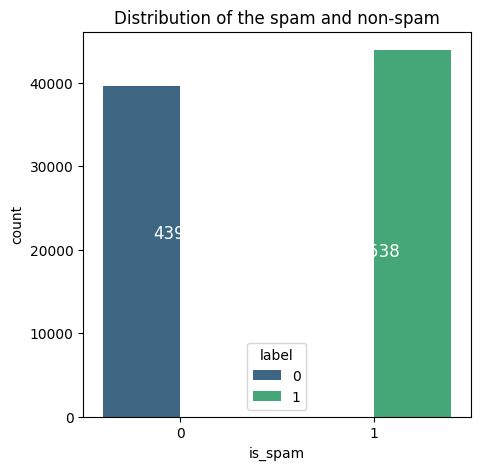

In [9]:
# Distribution of spam and non-spam email
plt.figure(figsize = (5,5))

ax = sns.countplot(x = df['label'], data = df, hue = 'label', palette = 'viridis')
plt.title('Distribution of the spam and non-spam')
plt.xlabel('is_spam')

for i, v in enumerate(list(df['label'].value_counts())):
  plt.text(i, v/2 , f'{v}', ha = 'center', va = 'center', color = 'white', fontsize = 12)
plt.show()

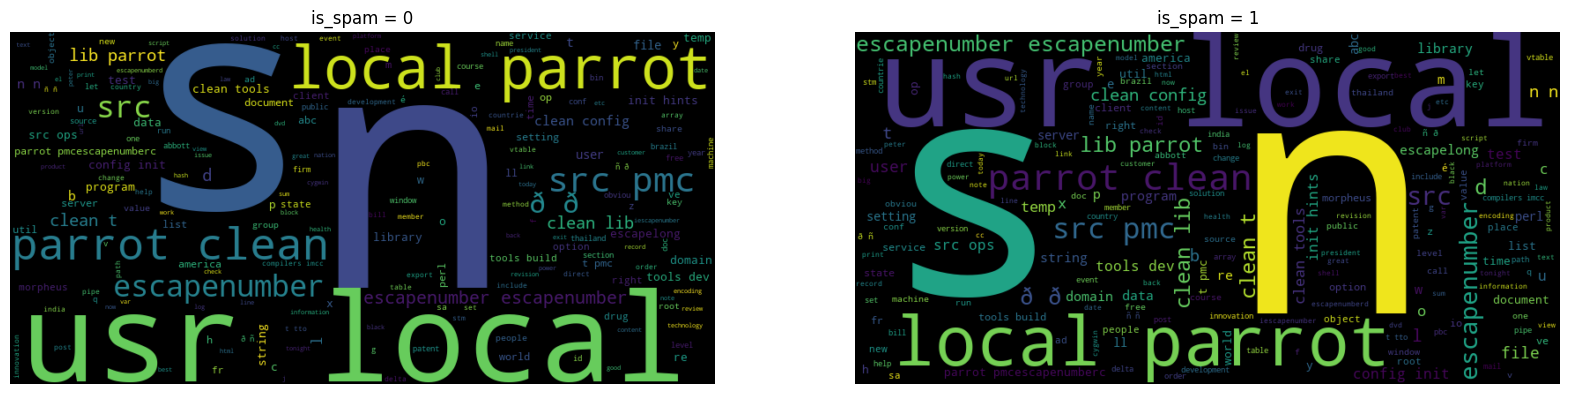

In [10]:
# Finding the most common used words
from collections import Counter
from wordcloud import WordCloud

# Functions to get most common words
def get_common_words(text, n = 20):
  words = ' '.join(text).split()
  common_words = Counter(words)
  return common_words

# Seperate spam and non-spam

score_0 = df[df['label'] == 0]['text']
score_1 = df[df['label'] == 1]['text']

# Get most common words

score0_common_words = get_common_words(score_0)
score1_common_words = get_common_words(score_1)

# Generate word clouds
score0_word_cloud = WordCloud(width = 800, height = 400).generate(' '.join(score0_common_words))
score1_word_cloud = WordCloud(width = 800, height = 400).generate(' '.join(score0_common_words))

# Plot word clouds
score_word_clouds = [score0_word_cloud, score1_word_cloud]
plt.figure(figsize = (20,20))

for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.imshow(score_word_clouds[i], interpolation = 'bilinear')
  plt.axis('off')
  plt.title(f'is_spam = {i}')
plt.show()

In [11]:
train_text, test_text, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size = 0.30, random_state = 42)

print(train_text.shape)
print(test_text.shape)

print(train_labels.shape)
print(test_labels.shape)

(58413,)
(25035,)
(58413,)
(25035,)


In [12]:
# Converting text to a number vector
tfd_idk = TfidfVectorizer()
train_text_tfdidk = tfd_idk.fit_transform(train_text)
test_text_tfdidk = tfd_idk.transform(test_text)

## Bulid models:

### Logistic Regression:

In [13]:
from sklearn.linear_model  import LogisticRegression

params_dist = {
    'penalty': ['l1', 'l2'],
    'C' : [0, 0.001, 0.2, 0.4, 0.6, 0.8, 1.0, 10, 100, 1000]
}

log_reg = LogisticRegression(max_iter = 1000, random_state = 42)

log_reg_random_search = RandomizedSearchCV(estimator = log_reg, param_distributions = params_dist, cv=5,
                                           scoring = 'accuracy', n_jobs = -1, n_iter = 10)
log_reg_random_search.fit(train_text_tfdidk, train_labels)

print(f'Best parameters : {log_reg_random_search.best_params_}')
print(f'Best Score : {log_reg_random_search.best_score_}')

Best parameters : {'penalty': 'l2', 'C': 10}
Best Score : 0.987930755625813


In [14]:
y_pred = log_reg_random_search.predict(test_text_tfdidk)
class_report(test_labels, y_pred)

,precision,recall,f1-score,support
0,0.992327,0.984854,0.988576,11818.000000
1,0.986547,0.993191,0.989858,13217.000000
accuracy,0.989255,0.989255,0.989255,0.989255
macro avg,0.989437,0.989022,0.989217,25035.000000
weighted avg,0.989276,0.989255,0.989253,25035.000000


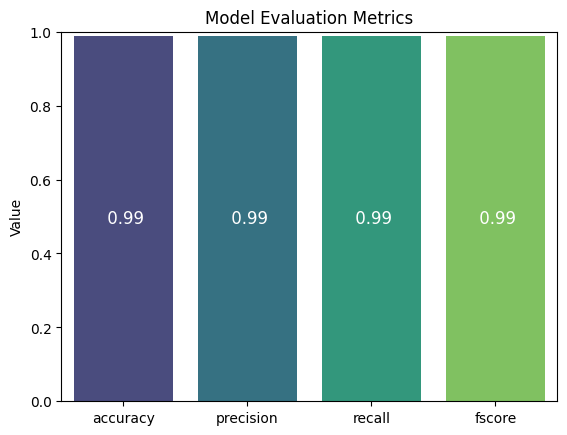

In [15]:
model_evaluation(test_labels, y_pred)

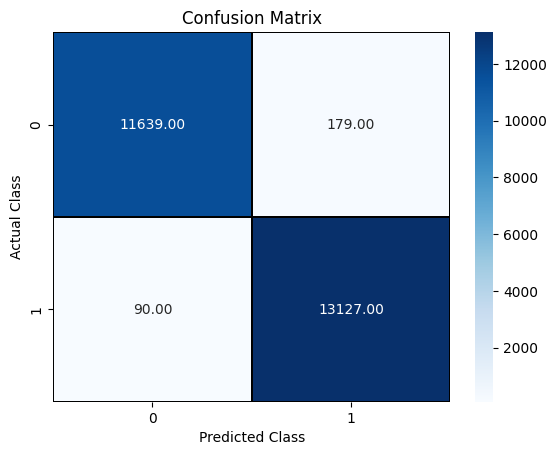

In [17]:
conf_matrix(test_labels, y_pred)

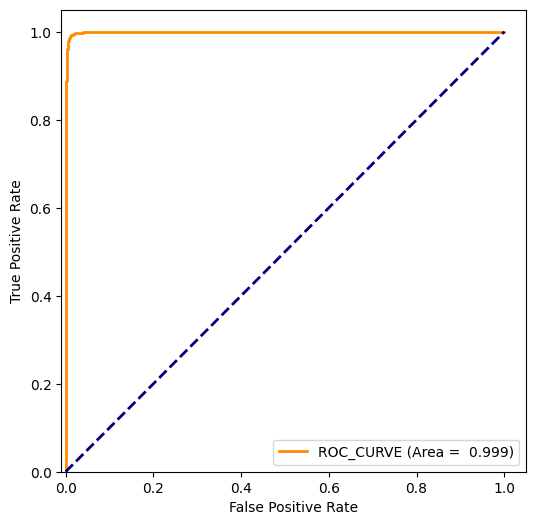

In [18]:
plot_roc(test_labels, log_reg_random_search.predict_proba(test_text_tfdidk)[:,1])

### Multi Nomial Naive Bayes:

In [19]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

params_dist = {
    'alpha' : [0.01, 0.1, 1, 10, 100, 1000]
}

mnb_random_search = RandomizedSearchCV(estimator = mnb, param_distributions = params_dist, cv=5,
                                           scoring = 'accuracy', n_jobs = -1, n_iter = 10)
mnb_random_search.fit(train_text_tfdidk, train_labels)

print(f'Best parameters : {mnb_random_search.best_params_}')
print(f'Best Score : {mnb_random_search.best_score_}')

Best parameters : {'alpha': 0.01}
Best Score : 0.9791142045277781


In [20]:
y_pred = mnb_random_search.predict(test_text_tfdidk)
class_report(test_labels, y_pred)

,precision,recall,f1-score,support
0,0.972241,0.989846,0.980964,11818.000000
1,0.990771,0.974730,0.982685,13217.000000
accuracy,0.981865,0.981865,0.981865,0.981865
macro avg,0.981506,0.982288,0.981825,25035.000000
weighted avg,0.982024,0.981865,0.981873,25035.000000


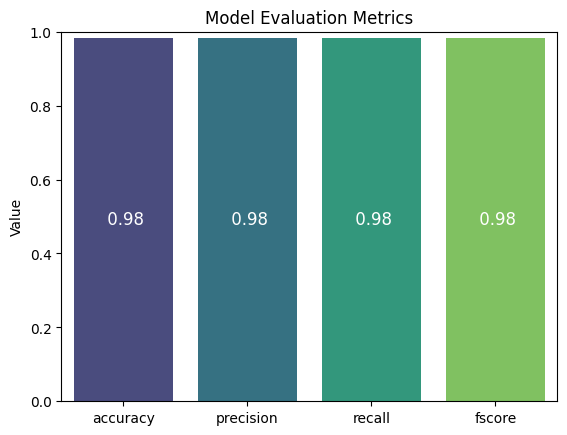

In [21]:
model_evaluation(test_labels, y_pred)

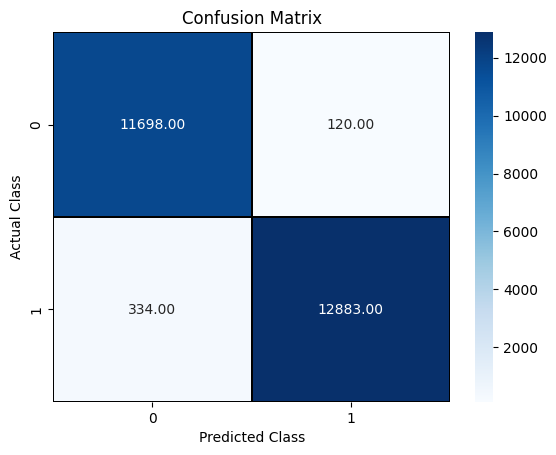

In [22]:
conf_matrix(test_labels, y_pred)

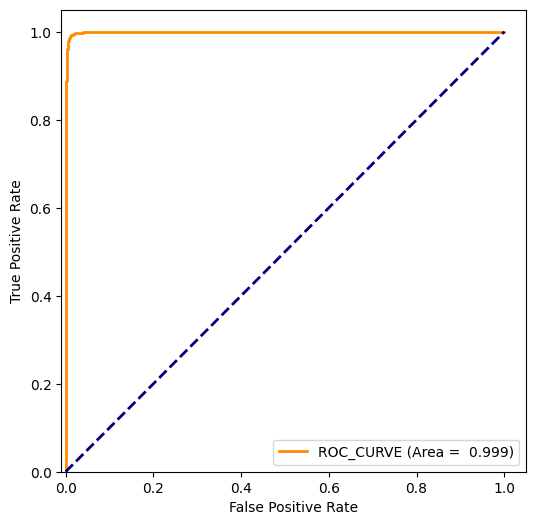

In [24]:
plot_roc(test_labels, log_reg_random_search.predict_proba(test_text_tfdidk)[:,1])

### Random Forest:

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

params_dist = {
    'n_estimators' : [10 * n for n in range(1,21)],
    'max_depth' : [2 * n for n in range(1,21)],
    'min_samples_leaf' : [n for n in range(1,11)],
    'min_samples_split' : [n for n in range(1,11)]
}

rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = params_dist,
                                  cv=5, n_jobs = -1, n_iter = 10, scoring = 'accuracy')
rf_random_search.fit(train_text_tfdidk, train_labels)

print(f'Best Parameters : {rf_random_search.best_params_}')
print(f"Best Score: {rf_random_search.best_score_}")

Best Parameters : {'n_estimators': 130, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 36}
Best Score: 0.9371715419089772


In [29]:
y_pred = rf_random_search.predict(test_text_tfdidk)
class_report(test_labels, y_pred)

,precision,recall,f1-score,support
0,0.986771,0.883652,0.932369,11818.000000
1,0.904857,0.989408,0.945246,13217.000000
accuracy,0.939485,0.939485,0.939485,0.939485
macro avg,0.945814,0.936530,0.938807,25035.000000
weighted avg,0.943526,0.939485,0.939167,25035.000000


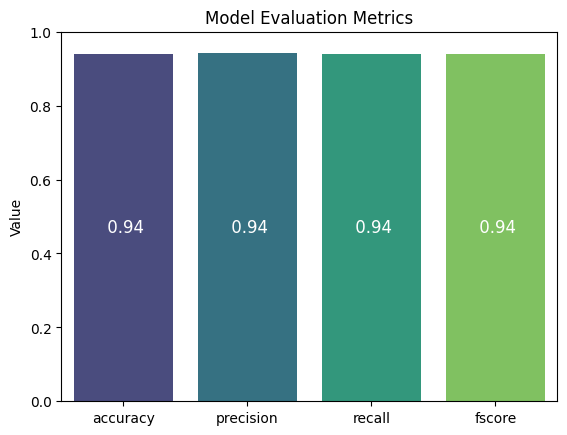

In [30]:
model_evaluation(test_labels, y_pred)

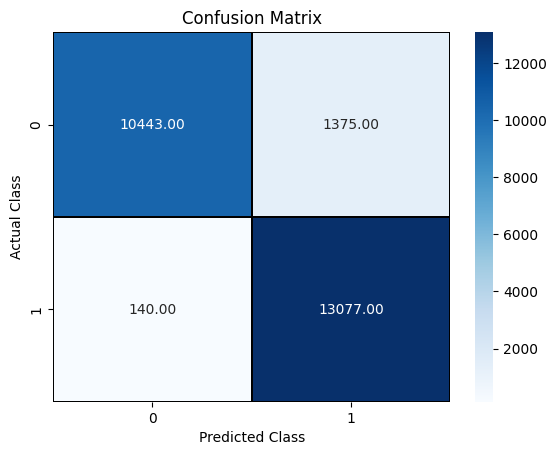

In [31]:
conf_matrix(test_labels, y_pred)

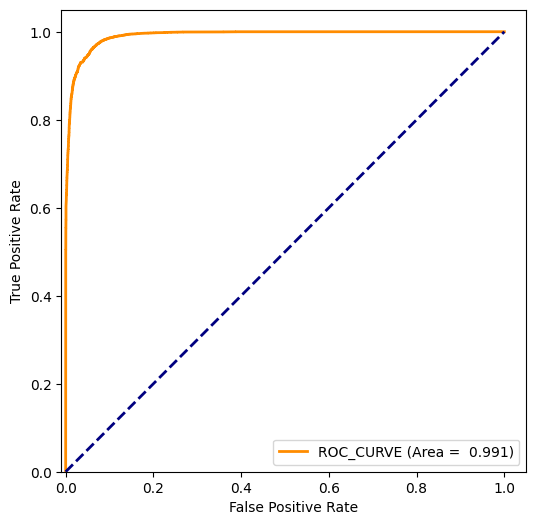

In [32]:
plot_roc(test_labels, rf_random_search.predict_proba(test_text_tfdidk)[:,1])

In [36]:
import joblib

joblib.dump(tfd_idk, "tfidf.pkl")          # vectoriseur
joblib.dump(log_reg, "spam_model.pkl") # modèle entraîné


['spam_model.pkl']